In [ ]:
from data import generate_dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

n = 1000

x, y, y_noisy1 = generate_dataset(n=n, noise_std=0.5, random_state=1)
_, _, y_noisy2 = generate_dataset(n=n, noise_std=1.0, random_state=1)
_, _, y_noisy3 = generate_dataset(n=n, noise_std=2.0, random_state=1)
_, _, y = generate_dataset(n=n, noise_std=0, random_state=1)

In [22]:

def gd_momentum(X_train, y_train, X_test, y_test, eta=0.01, num_iters=1000, gamma=0.9):
    n, d = X_train.shape
    theta = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        v = gamma * v + eta * grad
        theta -= v
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test

def gd_adagrad(X_train, y_train, X_test, y_test, eta=0.01, num_iters=1000, gamma=0.9, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)

    G = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        G += grad**2
        theta -= (eta / (np.sqrt(G) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test

def gd_rmsprop(X_train, y_train, X_test, y_test, eta=0.01, num_iters=1000, gamma=0.9, eps=1e-8, beta = 0.9):
    n, d = X_train.shape
    theta = np.zeros(d)
    Eg = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        Eg = beta * Eg + (1-beta) * grad**2
        theta -= (eta / (np.sqrt(Eg) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test

def gd_adam(X_train, y_train, X_test, y_test, eta=0.01, num_iters=1000, beta1=0.9, beta2=0.999, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for t in range(1, num_iters+1): 
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test




def design_matrix(x, degree):
    return np.vstack([x**i for i in range(degree+1)]).T

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)


_, _, y1_train, y1_test = train_test_split(x, y_noisy1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(x, y_noisy2, test_size=0.2, random_state=42)
_, _, y3_train, y3_test = train_test_split(x, y_noisy3, test_size=0.2, random_state=42)
_, _, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()

degrees = range(1, 16)



def run_optimizer_experiments(x_train, y_train, x_test, y_test,
                              degrees, num_iters=1000, etas=None):
    
    if etas is None:
        etas = [1e-6, 0.0001, 0.001, 0.01, 0.05]

    results = []

    for degree in degrees:
        X_train = design_matrix(x_train, degree)
        X_test  = design_matrix(x_test, degree)

        for eta in etas:  

       
            methods = {
                "Momentum": (lambda eta=eta: gd_momentum(X_train, y_train, X_test, y_test, eta=eta, num_iters=num_iters)),
                "AdaGrad":  (lambda eta=eta: gd_adagrad(X_train, y_train, X_test, y_test, eta=eta, num_iters=num_iters)),
                "RMSProp":  (lambda eta=eta: gd_rmsprop(X_train, y_train, X_test, y_test, eta=eta, num_iters=num_iters)),
                "Adam":     (lambda eta=eta: gd_adam(X_train, y_train, X_test, y_test, eta=eta, num_iters=num_iters)),
            }

            for name, f in methods.items():
                _, train_hist, test_hist = f()
                for t, (tr, te) in enumerate(zip(train_hist, test_hist), start=1):
                    results.append([name, degree, eta, t, tr, te])

    df = pd.DataFrame(results, columns=["Method", "Degree", "Eta", "Iteration", "Train MSE", "Test MSE"])
    return df


In [23]:
df_opt = run_optimizer_experiments(
    x_train_scaled, y1_train, x_test_scaled, y1_test,
    degrees=degrees, num_iters=1000, etas=[1e-6,0.0001, 0.001, 0.01, 0.05]
)

print(df_opt.head(10))


c:\hermanis\miniconda3\envs\geo\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\3421813683.py:65: RuntimeWarning: overflow encountered in square
  return np.mean((y - y_hat)**2)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\3421813683.py:7: RuntimeWarning: overflow encountered in matmul
  grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\3421813683.py:7: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\3421813683.py:8: RuntimeWarning: invalid value encountered in add
  v = gamma * v + eta * grad
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\3421813683.py:10: RuntimeWarning: invali

     Method  Degree       Eta  Iteration  Train MSE  Test MSE
0  Momentum       1  0.000001          1   0.410571  0.400914
1  Momentum       1  0.000001          2   0.410570  0.400913
2  Momentum       1  0.000001          3   0.410569  0.400912
3  Momentum       1  0.000001          4   0.410568  0.400911
4  Momentum       1  0.000001          5   0.410567  0.400909
5  Momentum       1  0.000001          6   0.410565  0.400908
6  Momentum       1  0.000001          7   0.410563  0.400906
7  Momentum       1  0.000001          8   0.410561  0.400904
8  Momentum       1  0.000001          9   0.410559  0.400902
9  Momentum       1  0.000001         10   0.410557  0.400899


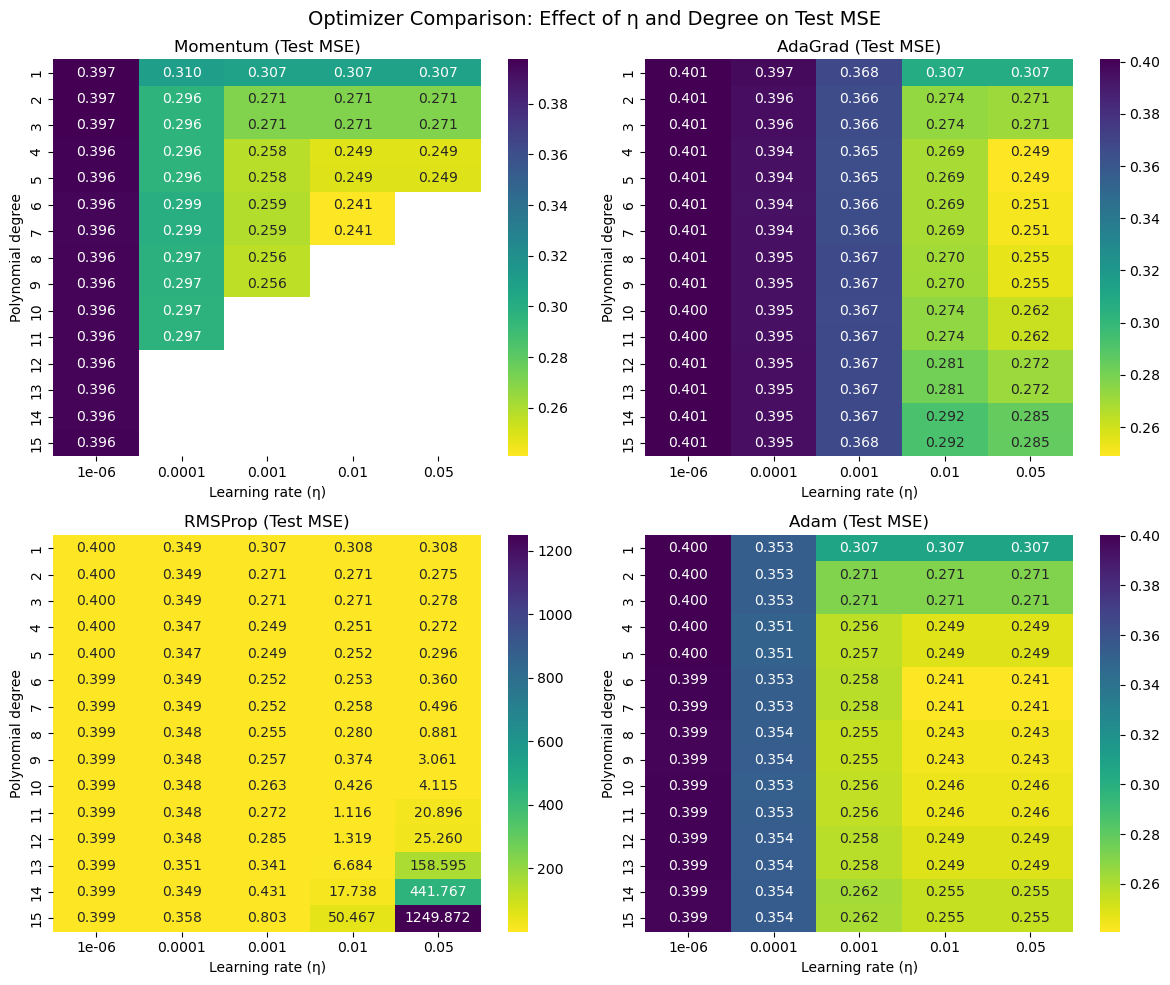

In [24]:

final_df = df_opt.groupby(["Method", "Degree", "Eta"]).tail(1)

fig, axes = plt.subplots(2, 2, figsize=(12,10))
methods = ["Momentum", "AdaGrad", "RMSProp", "Adam"]

for ax, method in zip(axes.flat, methods):
    subset = final_df[final_df["Method"] == method]
    pivot = subset.pivot_table(index="Degree", columns="Eta", values="Test MSE", aggfunc="mean")
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis_r", ax=ax)
    ax.set_title(f"{method} (Test MSE)")
    ax.set_xlabel("Learning rate (η)")
    ax.set_ylabel("Polynomial degree")

plt.suptitle("Optimizer Comparison: Effect of η and Degree on Test MSE", fontsize=14)
plt.tight_layout()
plt.show()


In [18]:
eta_value = 0.001
subset = df_opt[df_opt["Eta"] == eta_value]
print(subset.head())


Empty DataFrame
Columns: [Method, Degree, Eta, Iteration, Train MSE, Test MSE]
Index: []


In [19]:
best_eta = df_opt.loc[df_opt.groupby(["Method", "Degree"])["Test MSE"].idxmin()]
print(best_eta)


         Method  Degree   Eta  Iteration     Train MSE      Test MSE
1376    AdaGrad       1  0.05        377      0.325932      0.307403
5127    AdaGrad       2  0.05        128      0.281110      0.270819
9127    AdaGrad       3  0.05        128      0.281110      0.270811
13999   AdaGrad       4  0.05       1000      0.266657      0.248835
17999   AdaGrad       5  0.05       1000      0.266638      0.249005
21999   AdaGrad       6  0.05       1000      0.266063      0.250840
25999   AdaGrad       7  0.05       1000      0.266070      0.250787
29999   AdaGrad       8  0.05       1000      0.268848      0.254637
33999   AdaGrad       9  0.05       1000      0.268844      0.254645
37999   AdaGrad      10  0.05       1000      0.275559      0.261738
41999   AdaGrad      11  0.05       1000      0.275532      0.261795
45999   AdaGrad      12  0.05       1000      0.284935      0.271874
49999   AdaGrad      13  0.05       1000      0.284899      0.271949
53999   AdaGrad      14  0.05     

In [27]:
def gd_momentum_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, gamma=0.9):
    n, d = X_train.shape
    theta = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train)) + 2*lam*theta
        v = gamma * v + eta * grad
        theta -= v
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test

def gd_adagrad_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)
    G = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train)) + 2*lam*theta
        G += grad**2
        theta -= (eta / (np.sqrt(G) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test

def gd_rmsprop_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta=0.9, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)
    Eg = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train)) + 2*lam*theta
        Eg = beta * Eg + (1-beta) * grad**2
        theta -= (eta / (np.sqrt(Eg) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test

def gd_adam_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta1=0.9, beta2=0.999, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for t in range(1, num_iters+1):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train)) + 2*lam*theta
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test

def run_optimizer_experiments_ridge(
    x_train, y_train, x_test, y_test,
    degrees,
    lams=None,
    etas=None,
    num_iters=1000
):
    if lams is None:
        lams = [1e-6, 1e-3, 1, 3, 10]
    if etas is None:
        etas = [1e-6, 1e-4, 1e-3, 1e-2, 0.05]

    results = []

    for degree in degrees:
        X_train = design_matrix(x_train, degree)
        X_test  = design_matrix(x_test, degree)

        for lam in lams:
            for eta in etas:
                methods = {
                    "Momentum": (lambda lam=lam, eta=eta:
                        gd_momentum_ridge(X_train, y_train, X_test, y_test,
                                          lam=lam, eta=eta, num_iters=num_iters)),
                    "AdaGrad":  (lambda lam=lam, eta=eta:
                        gd_adagrad_ridge(X_train, y_train, X_test, y_test,
                                         lam=lam, eta=eta, num_iters=num_iters)),
                    "RMSProp":  (lambda lam=lam, eta=eta:
                        gd_rmsprop_ridge(X_train, y_train, X_test, y_test,
                                         lam=lam, eta=eta, num_iters=num_iters)),
                    "Adam":     (lambda lam=lam, eta=eta:
                        gd_adam_ridge(X_train, y_train, X_test, y_test,
                                      lam=lam, eta=eta, num_iters=num_iters)),
                }

                for name, f in methods.items():
                    _, train_hist, test_hist = f()
                    for t, (tr, te) in enumerate(zip(train_hist, test_hist), start=1):
                        results.append([name, degree, lam, eta, t, tr, te])

    df = pd.DataFrame(
        results,
        columns=["Method", "Degree", "Lambda", "Eta", "Iteration", "Train MSE", "Test MSE"]
    )
    return df



In [28]:
df_ridge = run_optimizer_experiments_ridge(
    x_train_scaled, y1_train, x_test_scaled, y1_test,
    degrees=range(1,16),
    lams=[1e-6, 1e-3, 1, 3, 10],
    etas=[1e-6, 1e-4, 1e-3, 1e-2, 0.05],
    num_iters=1000
)


c:\hermanis\miniconda3\envs\geo\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\3421813683.py:65: RuntimeWarning: overflow encountered in square
  return np.mean((y - y_hat)**2)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\562053470.py:7: RuntimeWarning: overflow encountered in matmul
  grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train)) + 2*lam*theta
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\562053470.py:7: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train)) + 2*lam*theta
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\562053470.py:8: RuntimeWarning: invalid value encountered in add
  v = gamma * v + eta * grad
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17652\562053470.py:10

In [29]:
final_df = (
    df_ridge.sort_values("Iteration")
            .groupby(["Method","Degree","Lambda","Eta"], as_index=False)
            .tail(1)
)


final_df = final_df[np.isfinite(final_df["Test MSE"])]
final_df = final_df[final_df["Test MSE"] < 1e3]


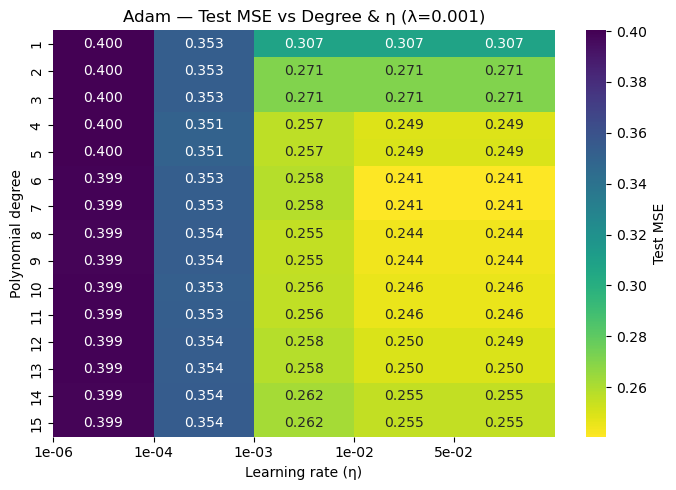

In [ ]:

lam_to_plot = 1e-3
method = "Adam"

subset = final_df[(final_df["Method"]==method) & (final_df["Lambda"]==lam_to_plot)]
pivot = subset.pivot_table(index="Degree", columns="Eta", values="Test MSE", aggfunc="mean")

plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis_r", cbar_kws={'label':'Test MSE'})
plt.title(f"{method} — Test MSE vs Degree & η (λ={lam_to_plot:g})")
plt.xlabel("Learning rate (η)")
plt.ylabel("Polynomial degree")

plt.xticks(ticks=range(len(pivot.columns)), labels=[f"{e:.0e}" for e in pivot.columns], rotation=0)
plt.tight_layout()
plt.show()


In [31]:
best_overall = final_df.loc[final_df.groupby("Method")["Test MSE"].idxmin()]
print(best_overall[["Method","Degree","Lambda","Eta","Test MSE"]])


          Method  Degree    Lambda    Eta  Test MSE
317999   AdaGrad       4  0.000001  0.050  0.248835
639999      Adam       7  0.001000  0.050  0.240525
612999  Momentum       7  0.000001  0.010  0.240962
310999   RMSProp       4  0.000001  0.001  0.249290


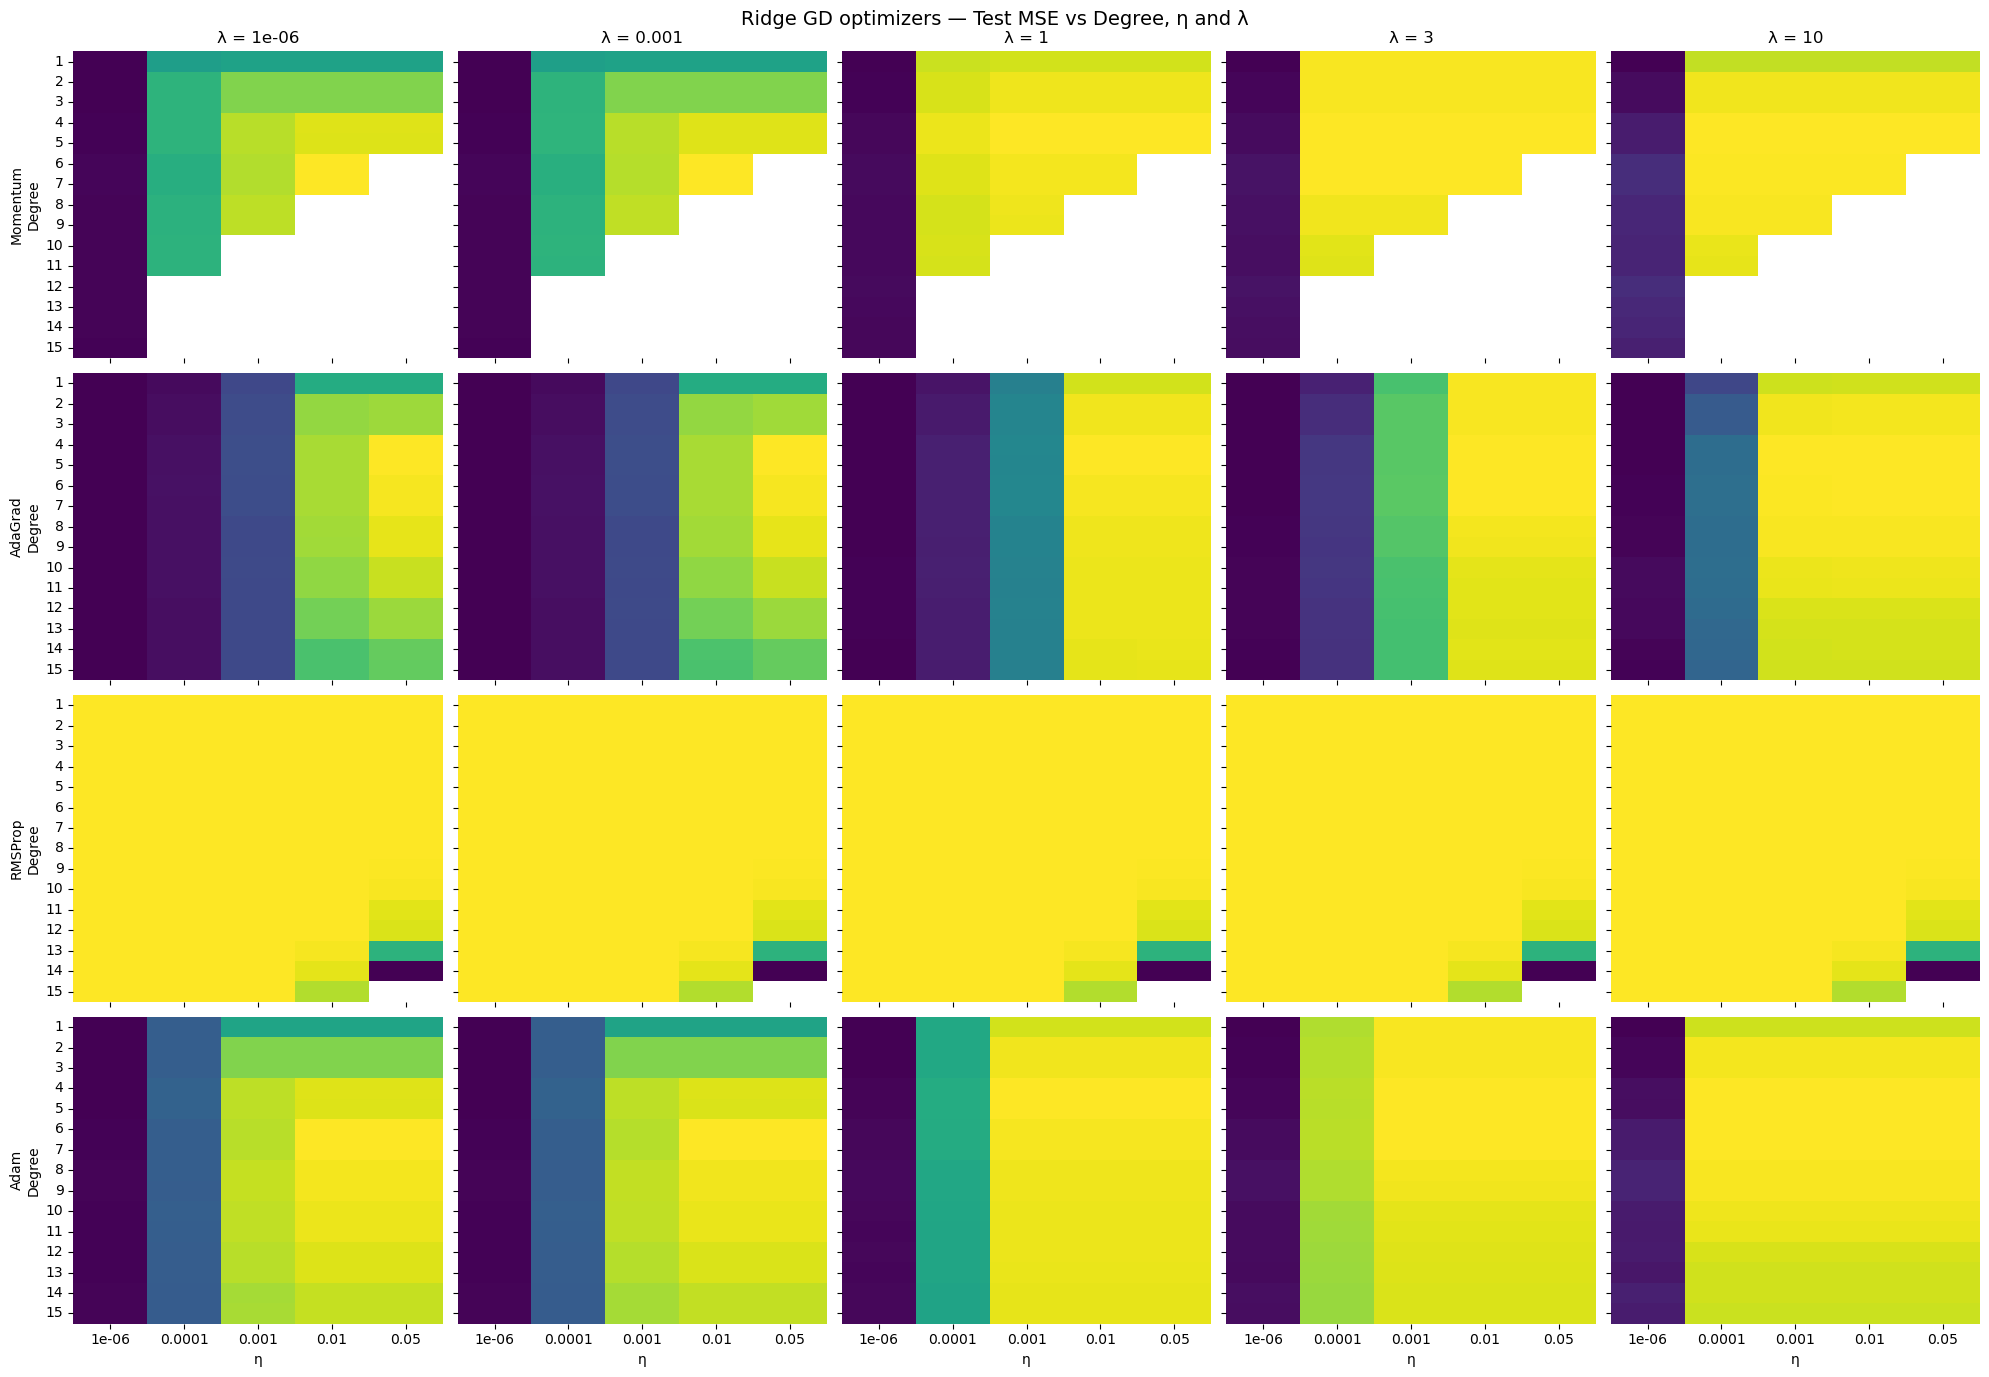

In [32]:
methods = ["Momentum", "AdaGrad", "RMSProp", "Adam"]
lambdas = sorted(final_df["Lambda"].unique())

fig, axes = plt.subplots(len(methods), len(lambdas), figsize=(4*len(lambdas), 3.5*len(methods)), sharex=True, sharey=True)

for i, method in enumerate(methods):
    for j, lam in enumerate(lambdas):
        ax = axes[i, j]
        subset = final_df[(final_df["Method"] == method) & (final_df["Lambda"] == lam)]
        pivot = subset.pivot_table(index="Degree", columns="Eta", values="Test MSE", aggfunc="mean")

        if pivot.empty:
            ax.axis("off")
            continue

        sns.heatmap(pivot, cmap="viridis_r", annot=False, ax=ax, cbar=False)
        if i == 0:
            ax.set_title(f"λ = {lam:g}")
        if j == 0:
            ax.set_ylabel(f"{method}\nDegree")
        else:
            ax.set_ylabel("")
        if i == len(methods)-1:
            ax.set_xlabel("η")
        else:
            ax.set_xlabel("")

plt.suptitle("Ridge GD optimizers — Test MSE vs Degree, η and λ", fontsize=14)
plt.tight_layout()
plt.show()
